In [8]:
MAKE_BOOK_FIGURES=Trueimport numpy as npimport scipy.stats as stimport matplotlib as mplimport matplotlib.pyplot as plt%matplotlib inlineimport matplotlib_inlinematplotlib_inline.backend_inline.set_matplotlib_formats('svg')import seaborn as snssns.set_context("paper")sns.set_style("ticks")def set_book_style():    plt.style.use('seaborn-v0_8-white')     sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings        'font.family': 'serif',  # For academic publishing        'font.size': 8,  # As requested, 10pt font        'axes.labelsize': 8,        'axes.titlesize': 8,        'xtick.labelsize': 7,  # Slightly smaller for better readability        'ytick.labelsize': 7,        'legend.fontsize': 7,                # Line and marker settings for consistency        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout to prevent clipped labels        'figure.constrained_layout.use': True,                # Default DPI (will override when saving)        'figure.dpi': 600,        'savefig.dpi': 600,                # Despine - remove top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional trim settings        'figure.autolayout': True,  # Alternative to constrained_layout        'savefig.bbox': 'tight',    # Trim when saving        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off    })def set_notebook_style():    plt.style.use('seaborn-v0_8-white')    sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings - using default sizes        'font.family': 'serif',        'axes.labelsize': 10,        'axes.titlesize': 10,        'xtick.labelsize': 9,        'ytick.labelsize': 9,        'legend.fontsize': 9,                # Line and marker settings        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout settings        'figure.constrained_layout.use': True,                # Remove only top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional settings        'figure.autolayout': True,        'savefig.bbox': 'tight',        'savefig.pad_inches': 0.1    })def save_for_book(fig, filename, is_vector=True, **kwargs):    """    Save a figure with book-optimized settings.        Parameters:    -----------    fig : matplotlib figure        The figure to save    filename : str        Filename without extension    is_vector : bool        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.    **kwargs : dict        Additional kwargs to pass to savefig    """        # Set appropriate DPI and format based on figure type    if is_vector:        dpi = 1000        ext = '.pdf'    else:        dpi = 600        ext = '.tif'        # Save the figure with book settings    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)def make_full_width_fig():    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)def make_half_width_fig():    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)if MAKE_BOOK_FIGURES:    set_book_style()else:    set_notebook_style()make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

# Hierarchical Bayesian Models

We build some relative simple hierarchical Bayesian models in `pyro`.
Note that `pyro` does not always do Gibbs sampling.
Instead it uses the following approach:
- It transforms all the variables so that they have a real support (e.g., if they are positive we can work with their logarithm).
- It uses the computaional graph to compute the joint distribution of all the transformed.
- It uses NUTS to sample from the joint distribution.

In [ ]:
# Do this in Google Colab
!pip install pyro-ppl

## Example 1 - Coal Mining Disaster 

We are going to work on the Coal Mining disaster dataset. Consider the following time series dataset of recorded coal mining disasters in the UK from 1851 to 1962. Let us first import this dataset and visualize it.

In [3]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/coal_mining_disasters.csv"
download(url)

In [4]:
import pandas as pd

disaster_data = pd.read_csv('coal_mining_disasters.csv')
disaster_data.dropna()
disasters = disaster_data.disasters.values
years = disaster_data.year.values
disaster_data

,year,disasters
0,1851,4
1,1852,5
2,1853,4
3,1854,0
4,1855,1
...,...,...
106,1957,0
107,1958,0
108,1959,1
109,1960,0


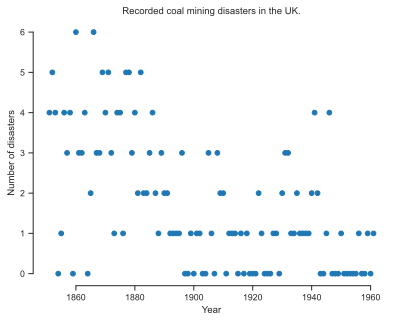

In [10]:
plt.figure()
plt.plot(disaster_data.year, disaster_data.disasters, 'o')
plt.xlabel('Year')
plt.ylabel('Number of disasters')
plt.title('Recorded coal mining disasters in the UK.')
sns.despine(trim=True);

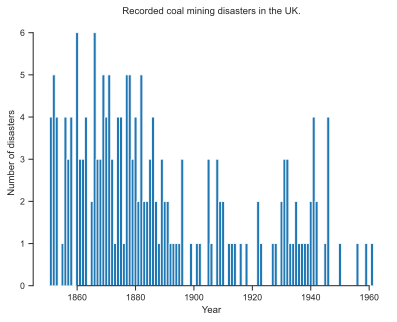

In [11]:
plt.figure()
bp = plt.bar(disaster_data.year, disaster_data.disasters, width=1.)
plt.xlabel("Year")
plt.ylabel("Number of disasters")
plt.title("Recorded coal mining disasters in the UK.")
sns.despine(trim=True);

### Questions

1. How can we represent this disaster time series data? What are the quantities of interests?
2. Is the 'disasters' variable categorial or continuous? Can it be negative? What are some other constraints?

### Information about the dataset 

Occurrences of disasters in the time series are thought to be derived from a Poisson process with a large rate parameter in the early part of the time series (more disasters in earlier years) and from one with a smaller rate in the later part (less number of disasters in later years). We are interested in locating the change point in the series, which might be because of changes in mining safety regulations in later years.

### Modeling Approach

How are we going to develop a model for these data? Thinking about how the data might be generated is a good starting point.* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated.

1. We start by thinking, "What is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So, we model the number of coal mining-related disasters sampled from a Poisson distribution.

2. Next, we think, "Okay, assuming the number of disasters is Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a rate parameter $\lambda$. 

3. Do we know $\lambda$? No. We suspect there are *two* $\lambda$ values, one for earlier and one for later years. We don't know when the change in this rate parameter occurs, though, but we call the switchpoint $\tau$.

4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well, the exponential distribution has a parameter too. Call it $\alpha$.

5. Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$. Still, it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$ ("it probably changes over time," "it's likely between 1 and 3", etc.), we don't have any strong beliefs about $\alpha$. 

6. We know that $\alpha$ is positive. But, we don't know its exact value. So, let's pick a distribution that assigns positive probability to positive numbers. The exponential distribution is a good choice. We will pick a rate parameter of 1.0 for the exponential distribution.

7. We have no expert opinion of when $\tau$ might have occurred. So, we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.
That's a bit tricky to do in Pyro, so we will use a trick: we will use a `pyro.sample` statement to sample a value from a uniform distribution, and then we will use a `pyro.deterministic` statement to deterministically transform that value into an integer in the correct range.

Here's a graphical model describing the relationships between the variables in our model:

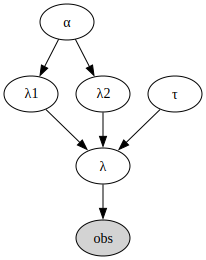

In [13]:
from graphviz import Digraph

gcp = Digraph('coal_mining_disasters_model')

# define the nodes 
gcp.node('alpha', label='<&alpha;>')
gcp.node('tau', label='<&tau;>')
gcp.node('lambda_1', label='<&lambda;<sub>1</sub>>')
gcp.node('lambda_2', label='<&lambda;<sub>2</sub>>')
gcp.node('lambda', label='<&lambda;>')
gcp.node('tau', label='<&tau;>')
gcp.node('obs', label='obs', style='filled')

# define the edges 
gcp.edge('alpha', 'lambda_1')
gcp.edge('alpha', 'lambda_2')
gcp.edge('tau', 'lambda')
gcp.edge('lambda_1', 'lambda')
gcp.edge('lambda_2', 'lambda')
gcp.edge('lambda', 'obs')
gcp

More formally, the generative model is expressed as:

$$\alpha \sim \mathrm{Exp}(1.0),$$

$$\lambda_1 \sim \mathrm{Exp}(\lambda_1 | \alpha),$$

$$\lambda_2 \sim \mathrm{Exp}(\lambda_2 | \alpha),$$

$$ \tau \sim \mathrm{Uniform}(1851, 1961), $$

$$\lambda_i = \begin{cases}
\lambda_1  & \text{if } t_i \lt \tau \cr
\lambda_2 & \text{if } t_i \ge \tau
\end{cases}$$

$$\mathrm{obs}_i \sim \mathrm{Poisson}(\lambda_i).$$

Here $t_i$ is the year of the $i$ th observation, and $\text{obs}_i$ is the number of disasters in year $i$.

We will set the rate parameter $\alpha$ on the exponential priors on $\lambda_1$ and $\lambda_2$ as a constant. 
The latent variables to be inferred are $\lambda_1, \lambda_2, \tau$.

Let's make this model in `pyro`.

In [135]:
import torch
import pyro
import pyro.distributions as dist


def model(years, disasters):
    alpha = 1.0
    years = torch.tensor(years)
    disasters = torch.tensor(disasters)
    tau = pyro.sample("tau", dist.Uniform(1851.0, 1962.0))
    lambda_1 = pyro.sample("lambda_1", dist.Exponential(alpha))
    lambda_2 = pyro.sample("lambda_2", dist.Exponential(alpha))
    with pyro.plate("data", size=disasters.shape[0]):
        lambda_ = pyro.deterministic(
            "lambda", 
            torch.where(torch.gt(tau, years), lambda_1, lambda_2)
        )
        pyro.sample("obs", dist.Poisson(lambda_), obs=disasters)
    return locals()

This was not that bad. But there is a problem. Let's try to sample from the model.

In [111]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=100)
mcmc.run(pt_years, pt_disasters)

Sample: 100%|██████████| 200/200 [01:29,  2.24it/s, step size=6.11e-03, acc. prob=0.633]



It takes forever. `pyro` can be very slow with sampling. It is good at variational inference (next lecture), but sometimes, if your model is complicated, it can take a long time to sample.
Fortunately, there is an alternative.
`numpyro` is a new library that is built on top of `jax` and `pyro`. It is much faster than `pyro` when it comes to sampling and has a similar interface. Let's try it out.
The main difference is that we will use `jax` instead of `torch` for the backend. I will highlight the points that differ.

In [137]:
# The imports are all different
import numpyro
import numpyro.distributions as dist
import jax
import jax.numpy as jnp


def model(years, disasters):
    alpha = 1.0
    # This is different
    years = jnp.array(years, dtype=jnp.float32)
    # And this
    disasters = jnp.array(disasters)
    # Here we only need to change the name of the library
    tau = numpyro.sample("tau", dist.Uniform(1851.0, 1962.0))
    lambda_1 = numpyro.sample("lambda_1", dist.Exponential(alpha))
    lambda_2 = numpyro.sample("lambda_2", dist.Exponential(alpha))
    with numpyro.plate("data", size=disasters.shape[0]):
        # Here we are using jax instead of torch
        lambda_ = numpyro.deterministic(
            "lambda",
            jnp.where(jax.lax.gt(tau, years), lambda_1, lambda_2)
        )
        numpyro.sample("obs", dist.Poisson(lambda_), obs=disasters)
    return locals()


from numpyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)

# This is also different
rng_key = jax.random.PRNGKey(0)
# And you need to pass it to the run method
mcmc.run(rng_key, jax_years, jax_disasters)

sample: 100%|██████████| 2000/2000 [00:02<00:00, 766.78it/s, 1023 steps of size 3.00e-04. acc. prob=0.88] 


Okay, that was fast. Let's look at the results.

In [122]:
# This is different btw, it used to be mcmc.summary()
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  lambda_1      1.93      0.10      1.92      1.79      2.10      7.80      1.02
  lambda_2      0.38      0.15      0.34      0.11      0.59     10.77      1.01
       tau   1946.65      0.46   1946.60   1946.00   1947.33     46.78      1.00

Number of divergences: 0


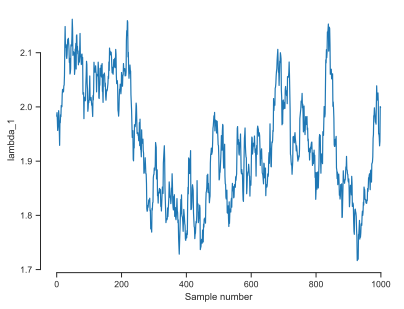

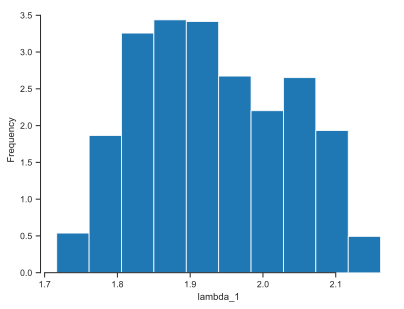

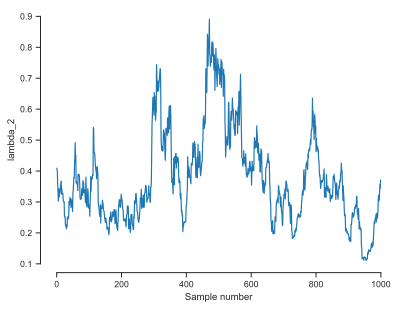

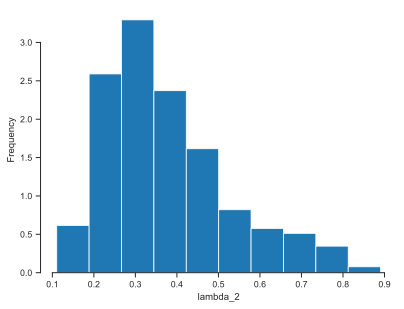

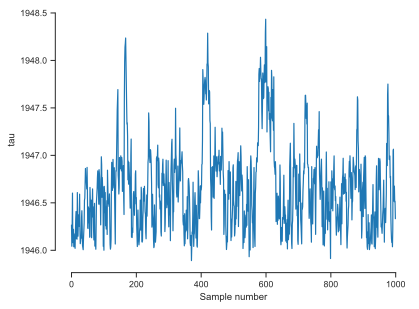

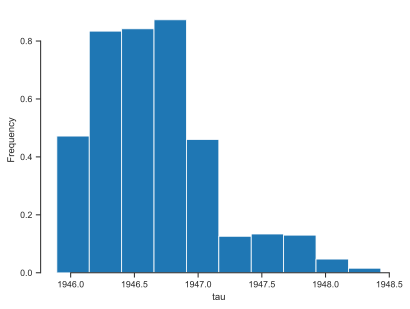

In [115]:
samples = mcmc.get_samples()
for param in samples.keys():
    fig, ax = plt.subplots()
    ax.plot(samples[param])
    ax.set(xlabel='Sample number', ylabel=param)
    sns.despine(trim=True);

    fig, ax = plt.subplots()
    ax.hist(samples[param], label=param, density=True)
    ax.set(xlabel=param, ylabel='Frequency')
    sns.despine(trim=True);

Let's finish by plotting the rate parameter $\lambda$ over time.
Recall that $\lambda$ is different depending on whether the year is before or after the switchpoint $\tau$.
Also, $\lambda$ is a deterministic function of $\lambda_1$, $\lambda_2$ and $\tau$.
It is not stored in the samples, but we can compute it from them.
This is done through the `numpyro.infer.Predictive`.
Here is how:

In [123]:
predict = numpyro.infer.Predictive(model, samples)(rng_key, jax_years, jax_disasters)

In [124]:
predict.items()

dict_items([('lambda', Array([[1.9828763 , 1.9828763 , 1.9828763 , ..., 0.40891236, 0.40891236,
        0.40891236],
       [1.9894089 , 1.9894089 , 1.9894089 , ..., 0.40647042, 0.40647042,
        0.40647042],
       [1.9763205 , 1.9763205 , 1.9763205 , ..., 0.39520258, 0.39520258,
        0.39520258],
       ...,
       [1.9366734 , 1.9366734 , 1.9366734 , ..., 0.35683027, 0.35683027,
        0.35683027],
       [2.000598  , 2.000598  , 2.000598  , ..., 0.3435446 , 0.3435446 ,
        0.3435446 ],
       [1.9987974 , 1.9987974 , 1.9987974 , ..., 0.37061924, 0.37061924,
        0.37061924]], dtype=float32)), ('obs', Array([[4, 5, 4, ..., 1, 0, 1],
       [4, 5, 4, ..., 1, 0, 1],
       [4, 5, 4, ..., 1, 0, 1],
       ...,
       [4, 5, 4, ..., 1, 0, 1],
       [4, 5, 4, ..., 1, 0, 1],
       [4, 5, 4, ..., 1, 0, 1]], dtype=int32))])

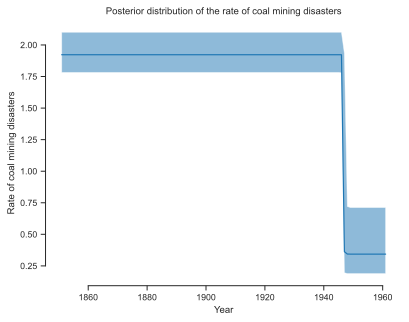

In [129]:
fig, ax = plt.subplots()
lambda_050 = jnp.quantile(predict["lambda"], 0.05, axis=0)
lambda_500 = jnp.quantile(predict["lambda"], 0.5, axis=0)
lambda_950 = jnp.quantile(predict["lambda"], 0.95, axis=0)
ax.plot(jax_years, lambda_500)
ax.fill_between(jax_years, lambda_050, lambda_950, alpha=0.5)
ax.set(xlabel="Year", ylabel="Rate of coal mining disasters")
ax.set_title("Posterior distribution of the rate of coal mining disasters")
sns.despine(trim=True);

## Example 2 - Challenger Space Shuttle Disaster

For this tutorial, we will work on the Challenger space shuttle disaster dataset.
We have revisited the problem in [HW 5](https://colab.research.google.com/github/PredictiveScienceLab/data-analytics-se/blob/master/homework/homework_05.ipynb). There, we used logistic regression, and we trained it with maximum likelihood.
We can now follow a Bayesian approach to the fullest extent.

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster. This failure was due to a faulty design that made the O-ring unacceptably sensitive to several factors, including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23 (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch. Unfortunately, only the data corresponding to the seven flights on which there was a damage incident were considered important, and these were thought to show no obvious trend. The data are shown below:

In [138]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

In [139]:
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


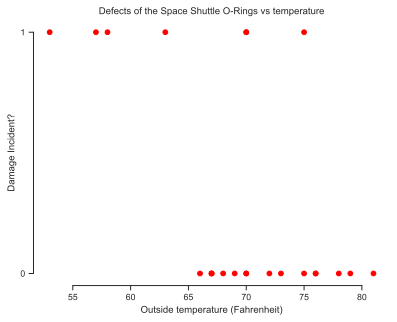

In [142]:
# plot it, as a function of temperature (the first column)
plt.figure()
plt.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro')
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature")
plt.yticks([0, 1])
sns.despine(trim=True);

### Information about the dataset 
It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask, "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

### Questions

+ How can we represent this disaster binary 1/0 data? What are the quantities of interests?
+ Is the "damage incident" variable categorical or continuous? What are some other constraints?

### Modeling Approach

How are we going to develop a model for this data? Thinking about how this data might be generated is a good starting point.* Try to imagine how you would recreate the dataset. We begin by asking how our observations might have been generated.

- We start by thinking, "what is the best random variable to describe this binary categorical data?" A Bernoulli random variable is a good candidate because it can represent binary data. So, we model the `defect incident` variable as sampled from a Bernoulli distribution. A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:

$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p_i\; ), \;\; i=1..N$$

- Next, we think, "Okay, assuming the damage incident variable is Bernoulli-distributed, what do I need for the Bernoulli distribution?" Well, the Bernoulli distribution has a probability parameter $p_i$. 

-  Do we know the $p_i$ parameter? No. But, we suspect (intuition) that this parameter depends on outside temperature values. The lower the outside temperature value, the greater the probability of damage incident. The higher the outside temperature value, the less the probability of damage incident. With slight abuse in notation, we can define this as:

$$p_i = p(t_i) = \sigma(t_i),$$

where $\sigma: \mathbb{R} \rightarrow (0, 1)$ is a suitable function that maps arbitrary temperature values to the interval $(0, 1)$ (so that we can then interpret the output of $\sigma$ as a probability). For this problem, we are going to use the logistic link function, which is given as:

$$\sigma(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are shown below, with differing $\alpha$ and $\beta$ parameter values:

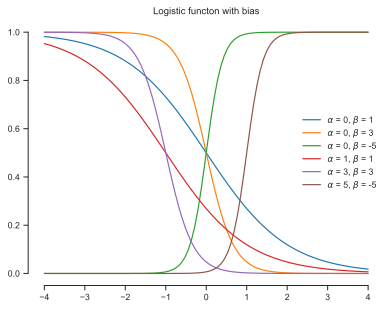

In [146]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)
plt.figure()
alphas = [0, 0, 0, 1, 3, 5]
betas  = [1, 3, -5, 1, 3, -5]
params = zip(alphas, betas)
for param in params:
    alpha, beta = param
    label="$\\alpha$ = %d, $\\beta$ = %d"%(alpha, beta)
    plt.plot(x, logistic(x, beta, alpha),
             label=label
    )
plt.title("Logistic functon with bias")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

#### Question:
+ How can we represent  $\alpha$ and $\beta$ parameter values? Are they categorical or continuous? Do they need to be positive?__

The $\beta, \alpha$ parameters have no reason to be positive, bounded, or relatively large, so they are best modeled by a *Normal random variable*. Since we do not have any prior beliefs about the value of parameters beta or alpha, we place a vague prior Normal distribution (small precision, large variance) over their values.

The graphical model for the data generation process is shown below. 

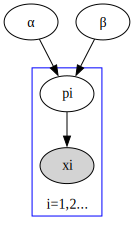

In [147]:
gcp = Digraph('space_shuttle_disaster')

# setup the nodes 
gcp.node('alpha', label='<&alpha;>')
gcp.node('beta', label='<&beta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('pi', label='<p<sub>i</sub>>')
    sg.node('xi', label='<x<sub>i</sub>>', style='filled')
    sg.attr(color='blue')
    sg.attr(label='i=1,2...')
    sg.attr(labelloc='b')

# setup the edges 
gcp.edge('alpha', 'pi')
gcp.edge('beta', 'pi')
gcp.edge('pi', 'xi')
gcp

### `Pyro` Implementation

In [148]:
def challenger(temperature, failure):
    alpha = numpyro.sample("alpha", dist.Normal(0, 10))
    beta = numpyro.sample("beta", dist.Normal(0, 10))
    p = numpyro.deterministic(
        "p", 
        1.0 / (1.0 + jnp.exp(beta * temperature + alpha))
    )
    x = numpyro.sample("x", dist.Bernoulli(p), obs=failure)
    return locals()

Here is how the model looks like graphically:

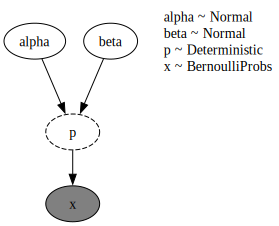

In [150]:
numpyro.render_model(challenger, model_args=(challenger_data[:, 0], challenger_data[:, 1]), render_distributions=True)

Let's sample from it:

In [151]:
nuts_kernel = NUTS(challenger)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key, challenger_data[:, 0], challenger_data[:, 1])
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1677.74it/s, 39 steps of size 7.18e-02. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    -11.21      5.33    -10.75    -19.99     -2.93    137.53      1.00
      beta      0.18      0.08      0.17      0.05      0.30    132.25      1.00

Number of divergences: 0


Here are all the posterior distributions:

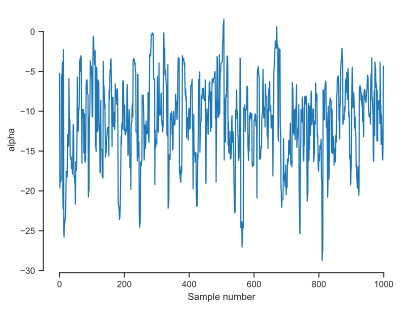

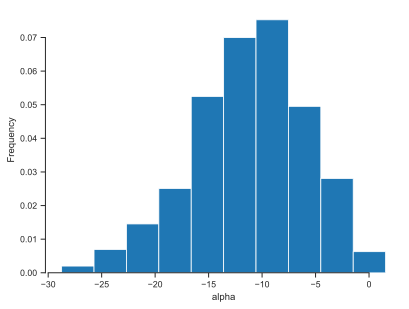

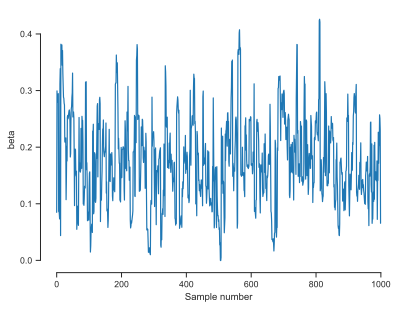

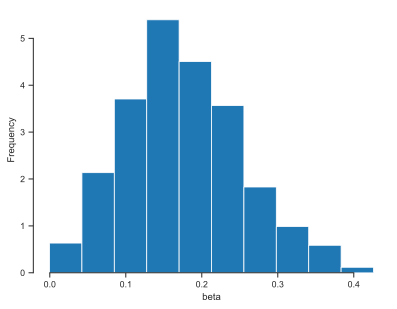

In [153]:
samples = mcmc.get_samples()
for param in samples.keys():
    if param == "p":
        continue
    fig, ax = plt.subplots()
    ax.plot(samples[param])
    ax.set(xlabel='Sample number', ylabel=param)
    sns.despine(trim=True);

    fig, ax = plt.subplots()
    ax.hist(samples[param], label=param, density=True)
    ax.set(xlabel=param, ylabel='Frequency')
    sns.despine(trim=True);

Let's now end with our prediction of the probability of a damage incident occurring at a given temperature.

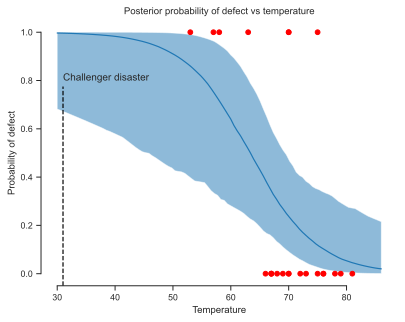

In [175]:
#probs = 1.0 / (1.0 + np.exp(-(samples["beta"] * temps.reshape(1, -1) + samples["alpha"]).T))
temps = np.linspace(30, challenger_data[:, 0].max() + 5, 100)[:, None]
probs = 1.0 / (1.0 + np.exp(samples["beta"] * temps + samples["alpha"]))

fig, ax = plt.subplots()
probs_025 = np.quantile(probs, 0.025, axis=1)
probs_500 = np.quantile(probs, 0.5, axis=1)
probs_975 = np.quantile(probs, 0.975, axis=1)
ax.plot(temps, probs_500)
ax.fill_between(temps.flatten(), probs_025, probs_975, alpha=0.5)
ax.set(xlabel="Temperature", ylabel="Probability of defect")
ax.set_title("Posterior probability of defect vs temperature")
ax.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro', label="observed")
ax.axvline(31, ymax=0.75, color="k", linestyle="--", label="Challenger disaster")
ax.text(31, 0.8, "Challenger disaster", fontsize=10)
sns.despine(trim=True);

The *95% credible interval*, or 95% CI, painted in blue, represents the interval for each temperature that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the defect probability lies between 0.25 and 0.75.

More generally, as the temperature nears 60 degrees, the CIs spread out quickly. As we pass 70 degrees, the CIs tighten again. This can give us insight into how to proceed: we should test more O-rings around 60-65 temperature to estimate probabilities in that range better. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability. As we can see, this does not reflect how *wide* the posterior distribution is.

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger would be subject to defective O-rings.